# Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import gc

import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Data Load

- 데이터 정보

In [55]:
info = pd.read_csv("data_info.csv")
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


- 메모리를 줄이기 위해 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업으로 사용 가능

In [56]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')
    
csv_to_parquet('train.csv', 'train')
csv_to_parquet('test.csv', 'test')

train Done.
test Done.


In [57]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [58]:
display(train.sample(3))
display(train.shape)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
3553387,TRAIN_3553387,20220211,금,2,3,103,일반국도12호선,0,0,70.0,...,0,동홍사거리,33.254628,126.567678,없음,중앙교,33.254233,126.565958,없음,46.0
1324938,TRAIN_1324938,20220725,월,12,1,103,일반국도16호선,0,0,60.0,...,3,제2회수교,33.261655,126.452658,없음,제2회수교,33.261690,126.453102,없음,50.0
2138080,TRAIN_2138080,20210924,금,6,3,103,일반국도12호선,0,0,70.0,...,0,화북남문입구삼거리,33.518740,126.565636,있음,진동1로,33.518987,126.568861,있음,41.0


(4701217, 23)

In [59]:
display(test.sample(3))
display(test.shape)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
230778,TEST_230778,20220806,토,19,1,103,일반국도16호선,0,0,50.0,...,0.0,0,월산1교,33.260178,126.490345,없음,월산2교,33.260056,126.490987,없음
214516,TEST_214516,20220808,월,18,1,107,태평로,0,0,50.0,...,0.0,0,동홍새마을금고,33.250671,126.572366,없음,반딧불식당,33.249551,126.571266,없음
175758,TEST_175758,20220810,수,14,1,107,시민광장로,0,0,30.0,...,0.0,0,중문농협,33.252510,126.508644,없음,제주렌트카,33.253348,126.508947,없음


(291241, 22)

# EDA

- data info

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   lane_count             291241 non-null  int64  
 5   road_rating            291241 non-null  int64  
 6   road_name              291241 non-null  object 
 7   multi_linked           291241 non-null  int64  
 8   connect_code           291241 non-null  int64  
 9   maximum_speed_limit    291241 non-null  float64
 10  vehicle_restricted     291241 non-null  float64
 11  weight_restricted      291241 non-null  float64
 12  height_restricted      291241 non-null  float64
 13  road_type              291241 non-null  int64  
 14  start_node_name        291241 non-nu

- data statistical information

In [62]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


In [63]:
train.describe(include='object')

,id,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
count,4701217,4701217,4701217,4701217,4701217,4701217,4701217
unique,4701217,7,61,487,2,487,2
top,TRAIN_0000000,금,일반국도12호선,고성교차로,없음,고성교차로,없음
freq,1,684024,1046092,42169,4239701,42265,4239599


In [64]:
test.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude
count,2.912410e+05,291241.000000,291241.000000,291241.000000,291241.0,291241.0,291241.000000,291241.0,291241.000000,291241.0,291241.000000,291241.000000,291241.000000,291241.000000,291241.000000
mean,2.022082e+07,11.856854,2.021371,105.245948,0.0,0.0,58.771430,0.0,3651.902033,0.0,0.634845,33.361624,126.512946,33.361651,126.512919
std,8.886111e+00,6.803378,0.750898,1.862653,0.0,0.0,11.390743,0.0,11327.618389,0.0,1.225362,0.116064,0.061478,0.116067,0.061344
min,2.022080e+07,0.000000,1.000000,103.000000,0.0,0.0,30.000000,0.0,0.000000,0.0,0.000000,33.243432,126.303780,33.243432,126.303780
25%,2.022081e+07,6.000000,1.000000,103.000000,0.0,0.0,50.000000,0.0,0.000000,0.0,0.000000,33.254214,126.476508,33.254214,126.476508
50%,2.022082e+07,12.000000,2.000000,106.000000,0.0,0.0,60.000000,0.0,0.000000,0.0,0.000000,33.272222,126.512046,33.272222,126.512046
75%,2.022082e+07,18.000000,3.000000,107.000000,0.0,0.0,70.000000,0.0,0.000000,0.0,0.000000,33.492718,126.561830,33.492718,126.561830
max,2.022083e+07,23.000000,3.000000,107.000000,0.0,0.0,80.000000,0.0,50000.000000,0.0,3.000000,33.521399,126.912948,33.521399,126.912948


In [65]:
test.describe(include='object')

,id,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
count,291241,291241,291241,291241,291241,291241,291241
unique,291241,7,46,250,2,252,2
top,TEST_000000,화,일반국도12호선,산신주유소,없음,산신주유소,없음
freq,1,47452,50140,3590,246968,3538,246953


- 결측치 확인

In [66]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [67]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

### 데이터 시각화
###### 참고 : https://dacon.io/competitions/official/235985/codeshare/6856?page=1&dtype=recent

- 추이 그래프

In [68]:
# 시각화를 위한 그룹화
train_date = train[['base_date','target']]
train_date = train_date.groupby('base_date').mean().reset_index()
train_date['base_date'] = train_date['base_date'].astype(str)

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_name = train[['road_name','target']]
train_name = train_name.groupby('road_name').mean().reset_index()

display(train_date.head(3))
display(train_time.head(3))
display(train_day.head(3))
display(train_name.head(3))

,base_date,target
0,20210901,43.760268
1,20210902,43.769578
2,20210903,43.692354


,base_hour,target
0,0,48.742200
1,1,49.763300
2,2,50.278658


,day_of_week,target
0,월,42.761365
1,화,42.699198
2,수,42.770372


,road_name,target
0,-,44.774556
1,경찰로,24.686785
2,고평교,36.126862


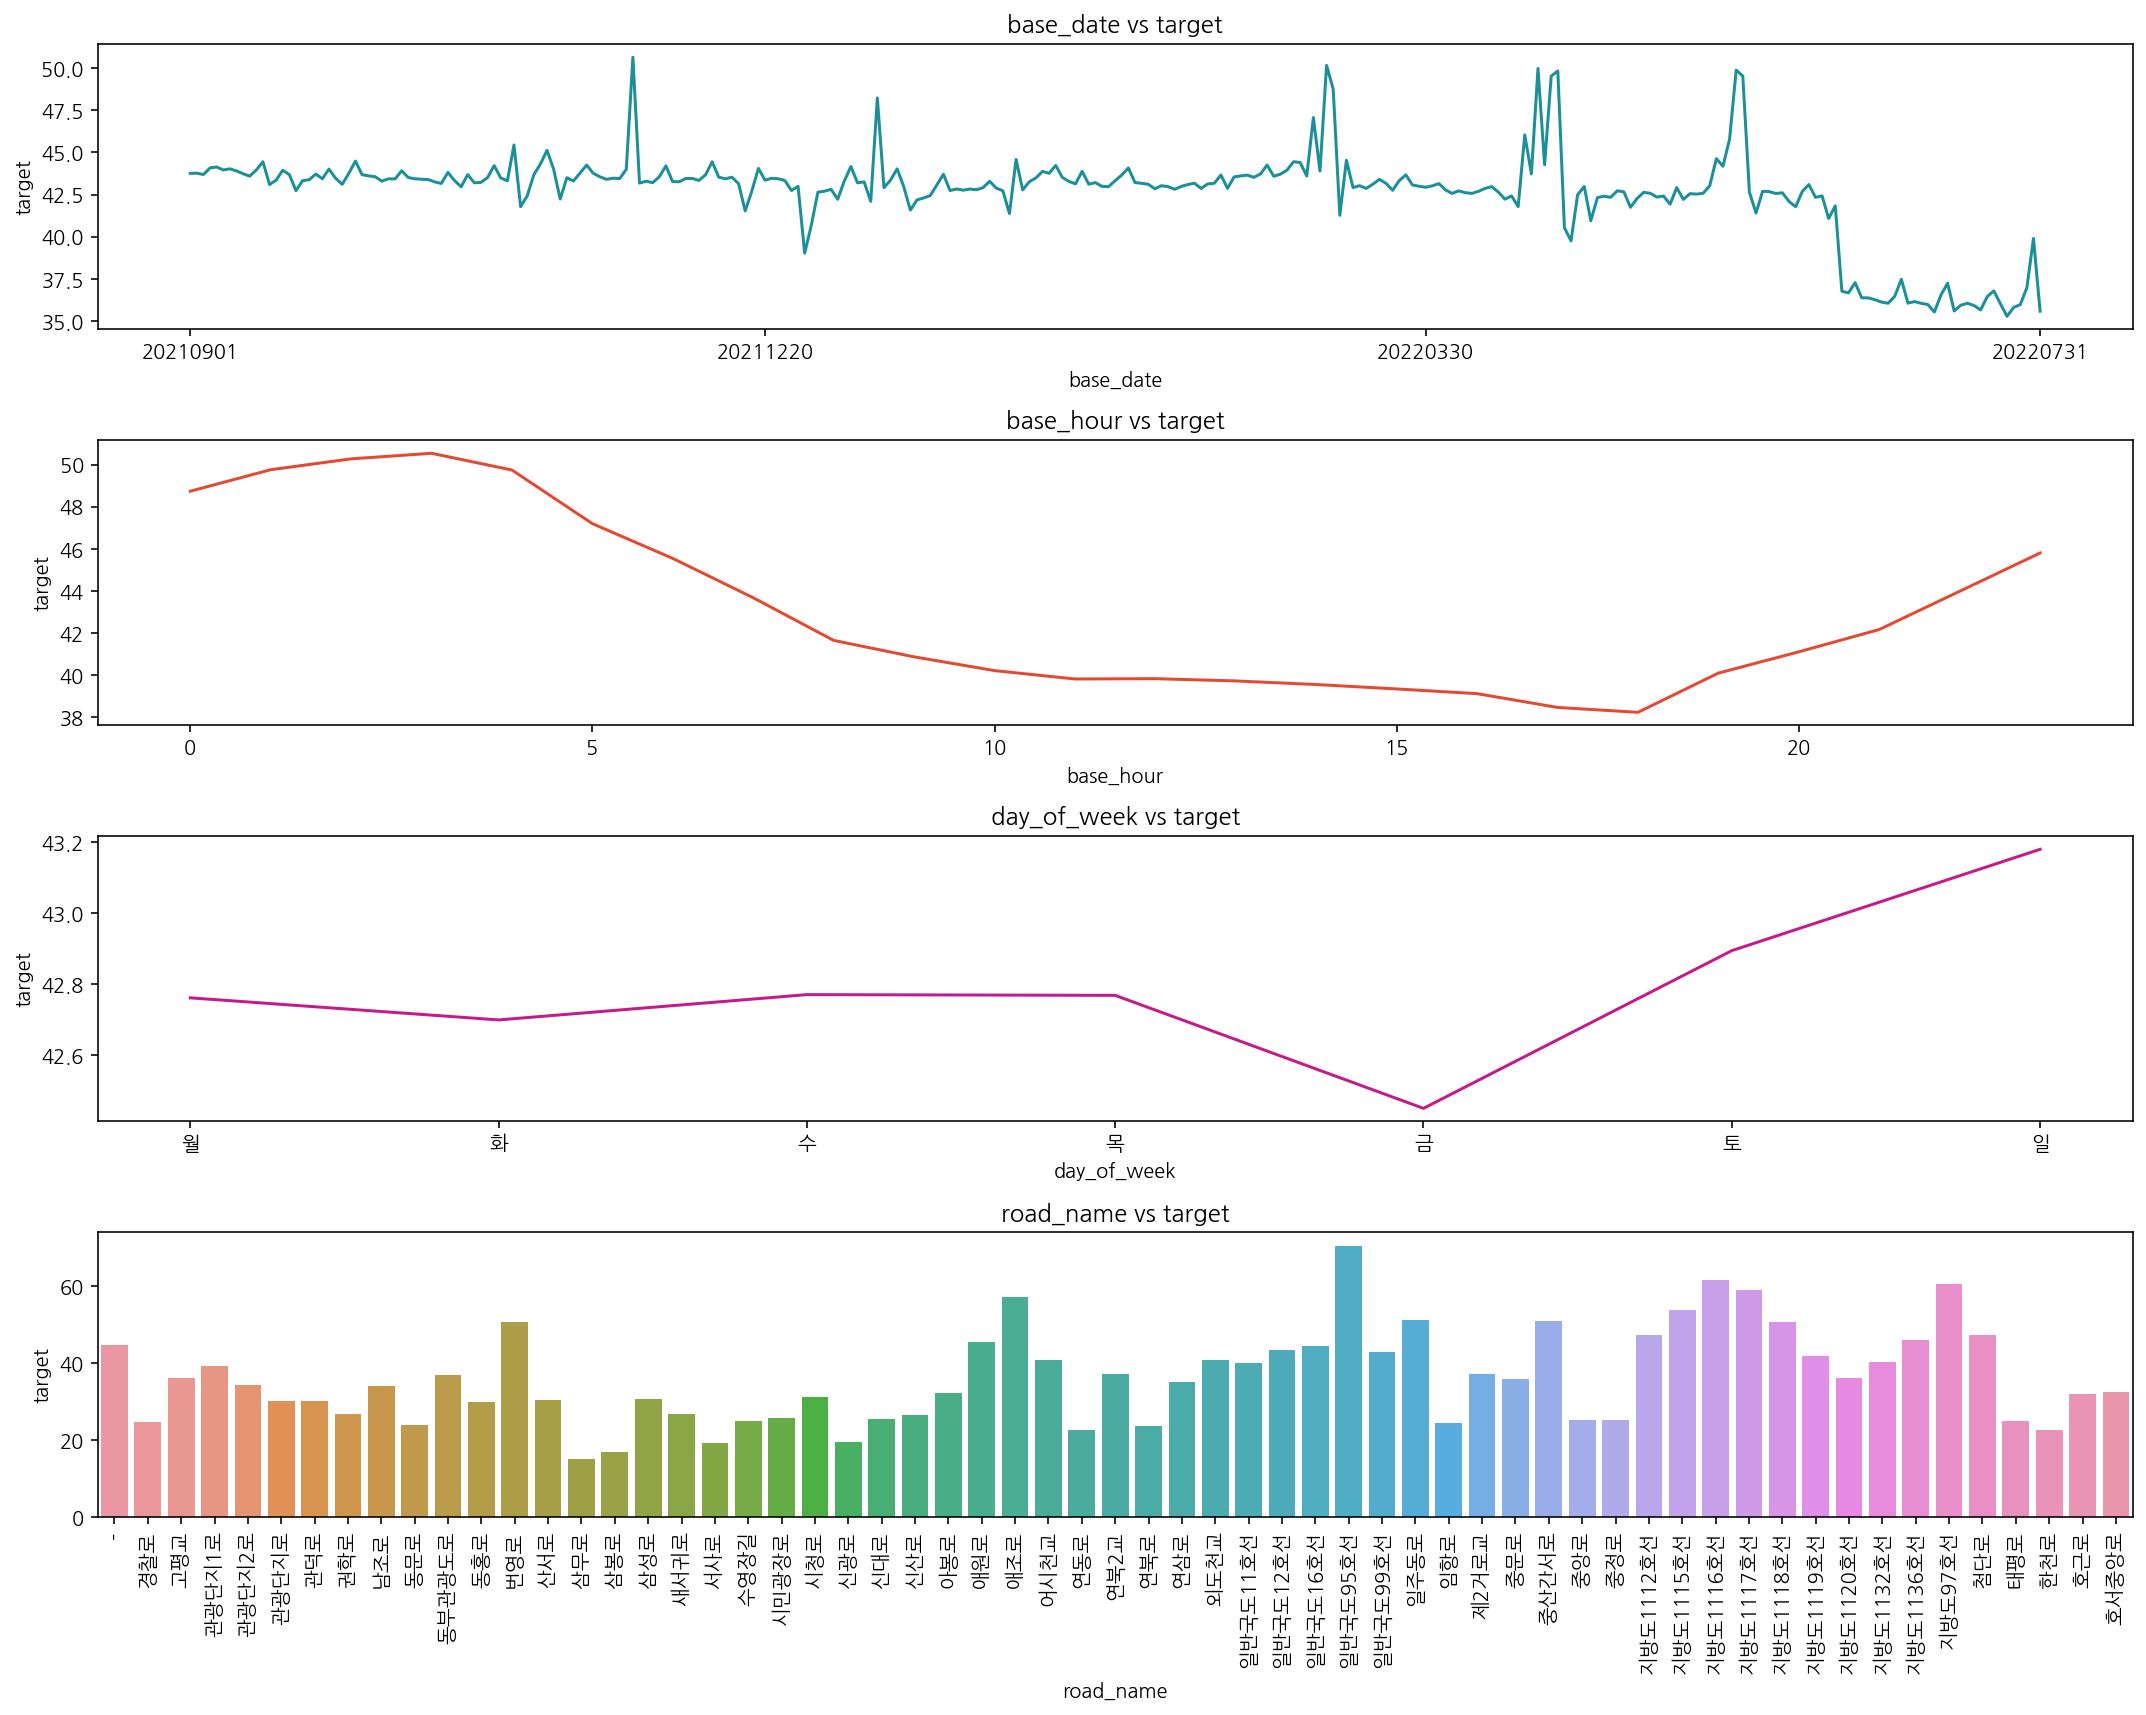

In [69]:
fig, axes = plt.subplots(4, figsize=(15,12))

sns.lineplot(x='base_date',y='target',data=train_date,ax=axes[0],color='#1c9099').set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1],color='#e34a33').set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2],color='#c51b8a').set(title='day_of_week vs target')
sns.barplot(x='road_name',y='target',data=train_name,ax=axes[3]).set(title='road_name vs target')

axes[0].set_xticks(['20210901', '20211220', '20220330', '20220731'])

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

- 년/월/일별 추이 그래프

In [88]:
# 시각화를 위한 그룹화

train_date['year'] = train_date['base_date'].map(lambda x : x[:4])
train_date['month']= train_date['base_date'].map(lambda x : x[4:6])
train_date['day']= train_date['base_date'].map(lambda x : x[6:])

train_date

,base_date,target,year,month,day
0,20210901,43.760268,2021,09,01
1,20210902,43.769578,2021,09,02
2,20210903,43.692354,2021,09,03
3,20210904,44.084787,2021,09,04
4,20210905,44.136858,2021,09,05
...,...,...,...,...,...
276,20220727,35.810005,2022,07,27
277,20220728,35.973425,2022,07,28
278,20220729,36.981121,2022,07,29
279,20220730,39.905149,2022,07,30


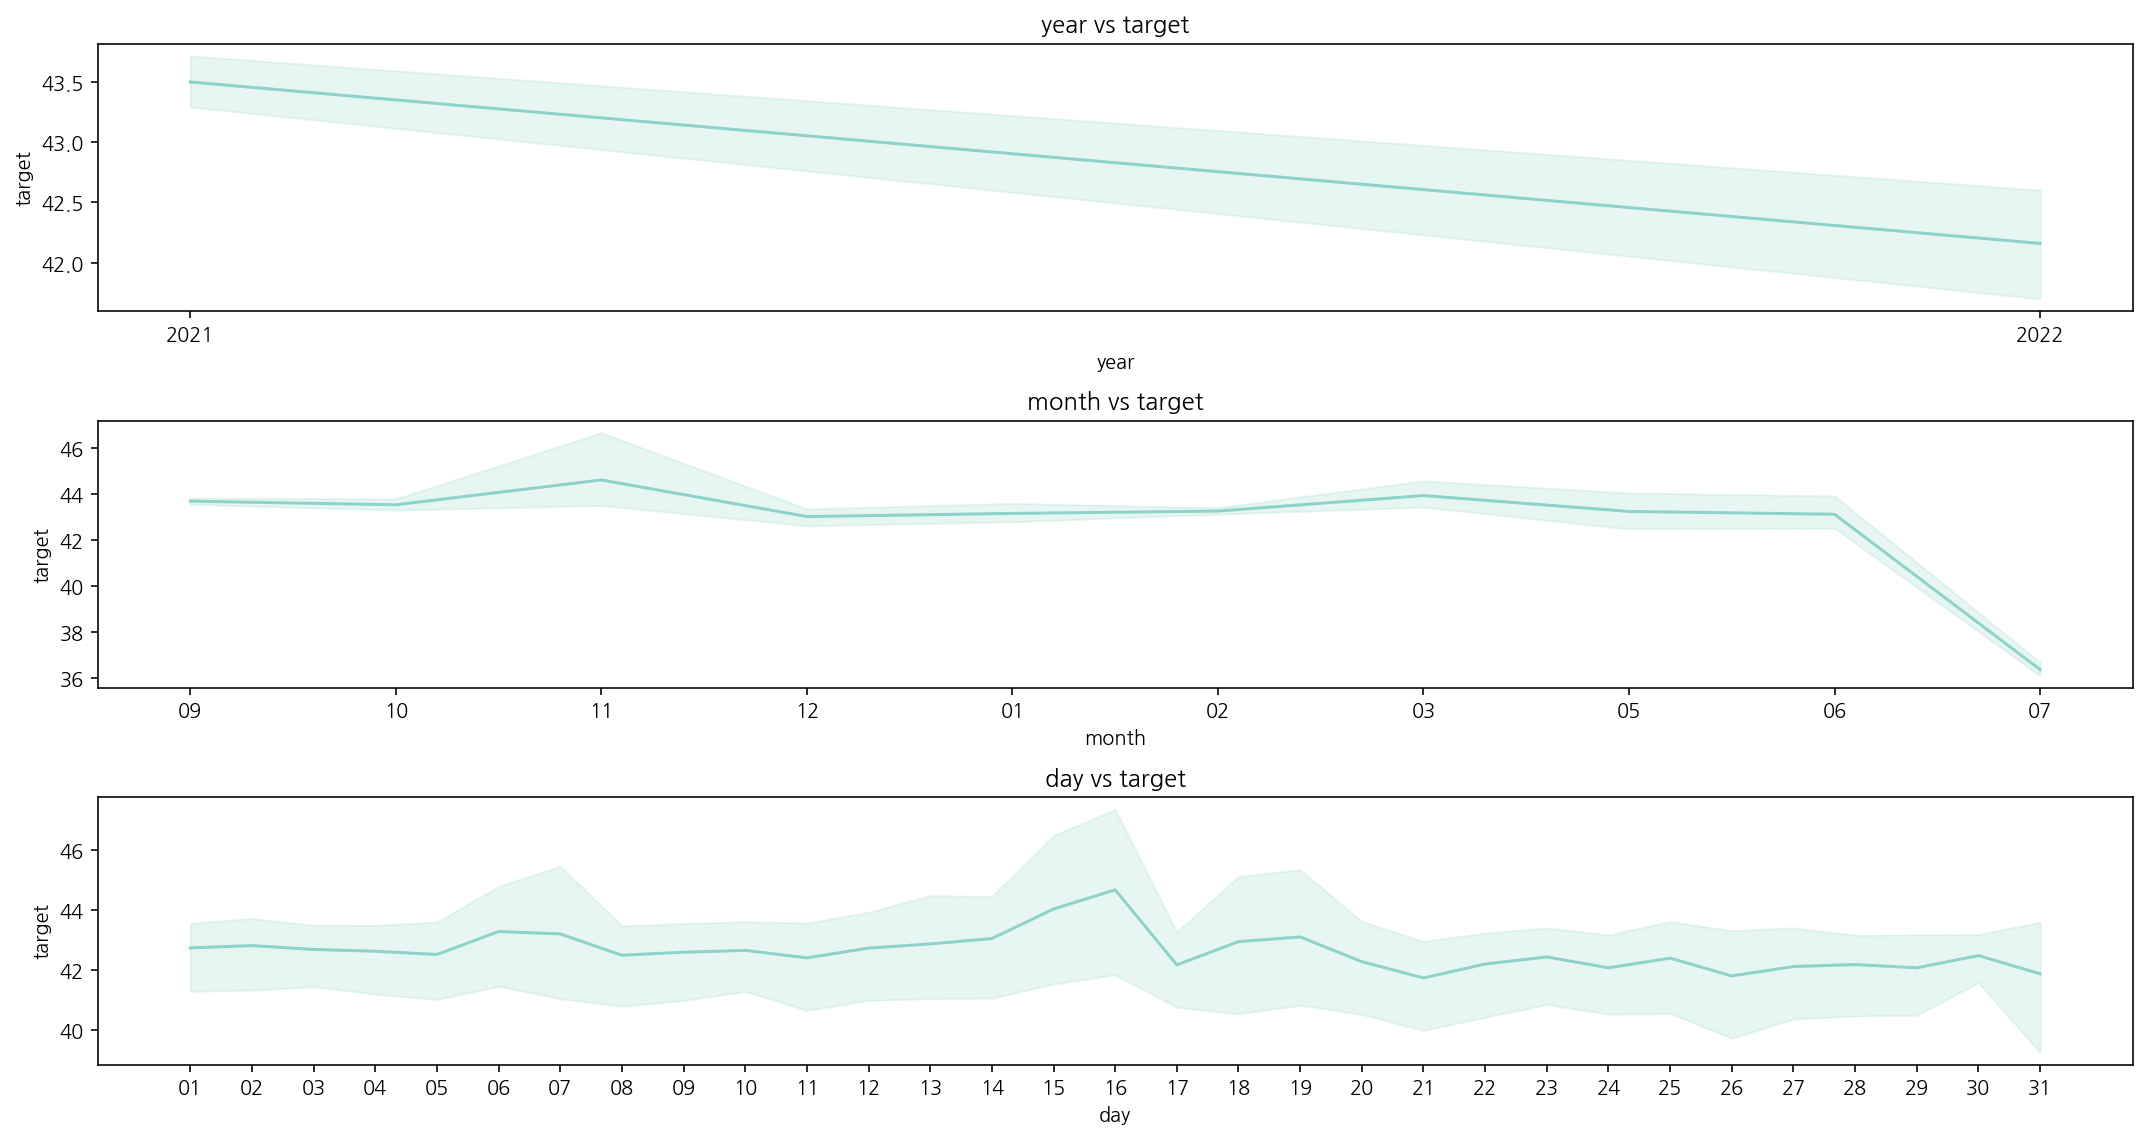

In [90]:
fig, axes = plt.subplots(3, figsize=(15,8))

sns.lineplot(x='year',y='target',data=train_date,ax=axes[0]).set(title='year vs target')
sns.lineplot(x='month',y='target',data=train_date,ax=axes[1]).set(title='month vs target')
sns.lineplot(x='day',y='target',data=train_date,ax=axes[2]).set(title='day vs target')

plt.tight_layout()
plt.show()

- train/test 비교 그래프

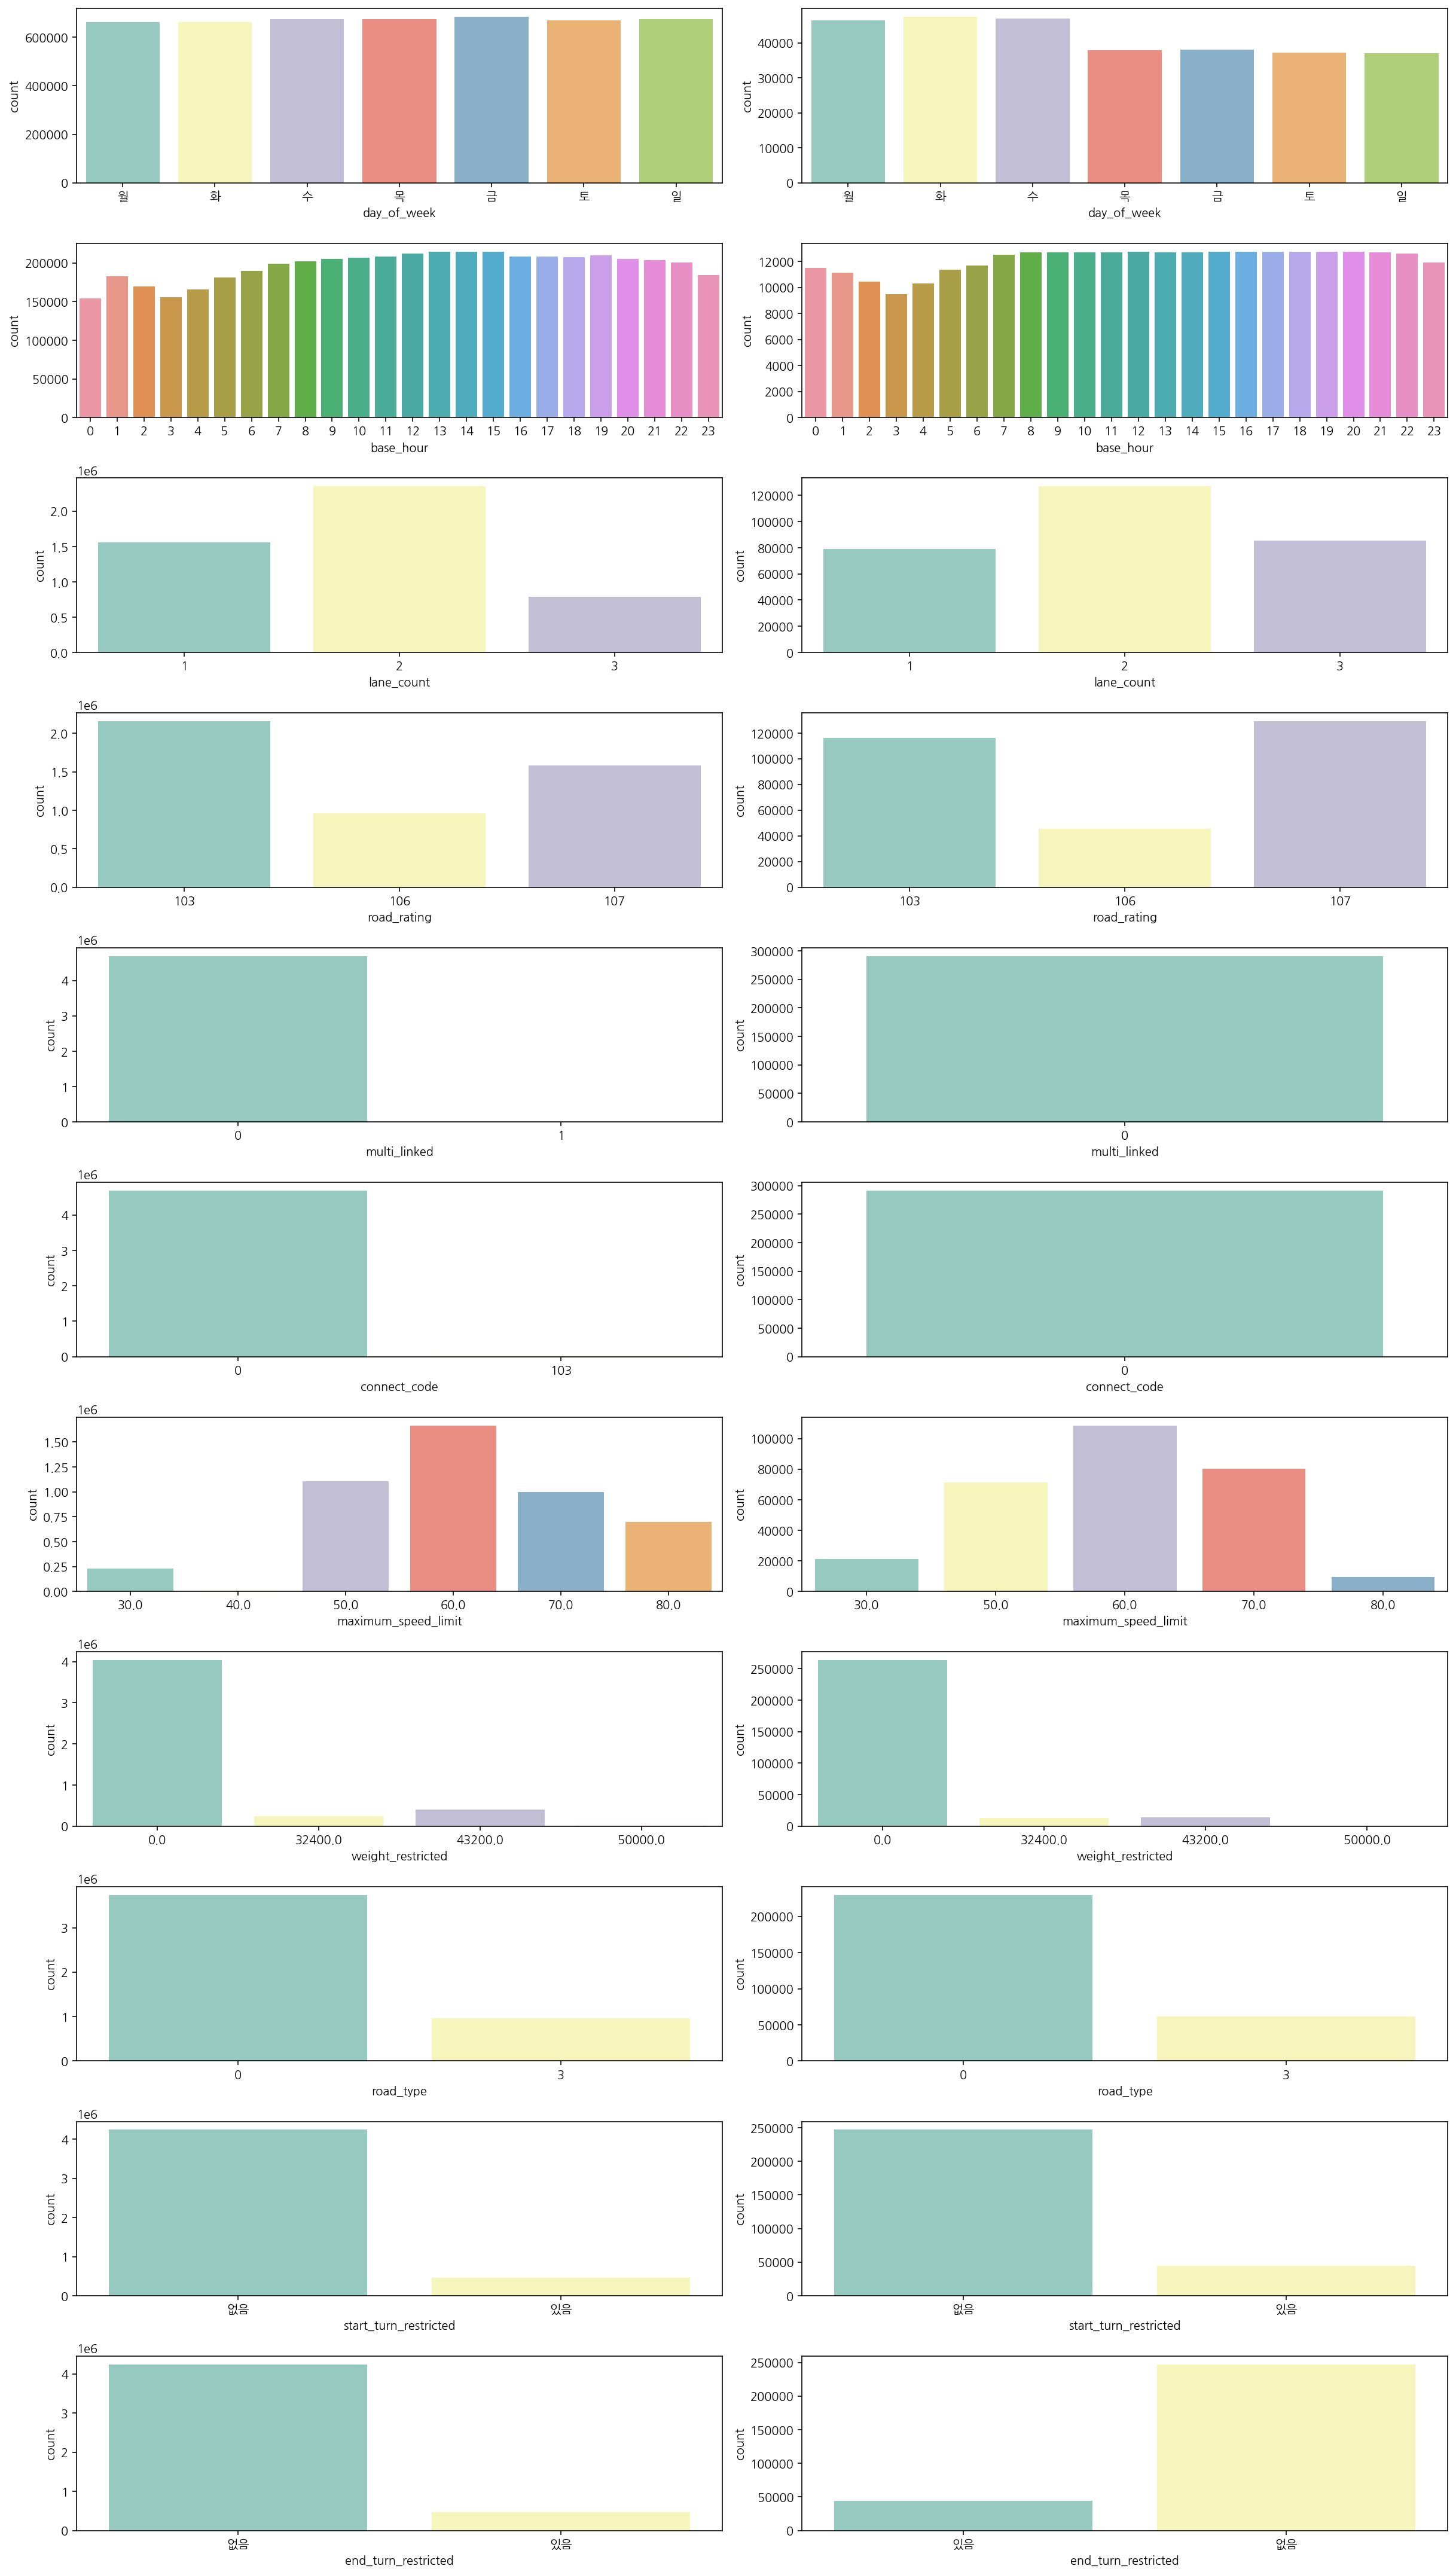

In [93]:
date_order = ['월','화','수','목','금','토','일']

fig, axes = plt.subplots(11, 2, figsize=(17,30))

sns.color_palette("bright")
sns.countplot(x='day_of_week', data=train, ax=axes[0][0],order=date_order)
sns.countplot(x='day_of_week', data=test, ax=axes[0][1],order=date_order)
sns.countplot(x='base_hour', data=train, ax=axes[1][0])
sns.countplot(x='base_hour', data=test, ax=axes[1][1])
sns.countplot(x='lane_count', data=train, ax=axes[2][0])
sns.countplot(x='lane_count', data=test, ax=axes[2][1])
sns.countplot(x='road_rating', data=train, ax=axes[3][0])
sns.countplot(x='road_rating', data=test, ax=axes[3][1])
sns.countplot(x='multi_linked', data=train, ax=axes[4][0])
sns.countplot(x='multi_linked', data=test, ax=axes[4][1])
sns.countplot(x='connect_code', data=train, ax=axes[5][0])
sns.countplot(x='connect_code', data=test, ax=axes[5][1])
sns.countplot(x='maximum_speed_limit', data=train, ax=axes[6][0])
sns.countplot(x='maximum_speed_limit', data=test, ax=axes[6][1])
sns.countplot(x='weight_restricted', data=train, ax=axes[7][0])
sns.countplot(x='weight_restricted', data=test, ax=axes[7][1])
sns.countplot(x='road_type', data=train, ax=axes[8][0])
sns.countplot(x='road_type', data=test, ax=axes[8][1])
sns.countplot(x='start_turn_restricted', data=train, ax=axes[9][0])
sns.countplot(x='start_turn_restricted', data=test, ax=axes[9][1])
sns.countplot(x='end_turn_restricted', data=train, ax=axes[10][0])
sns.countplot(x='end_turn_restricted', data=test, ax=axes[10][1])

plt.tight_layout()
plt.show()

- 상관계수

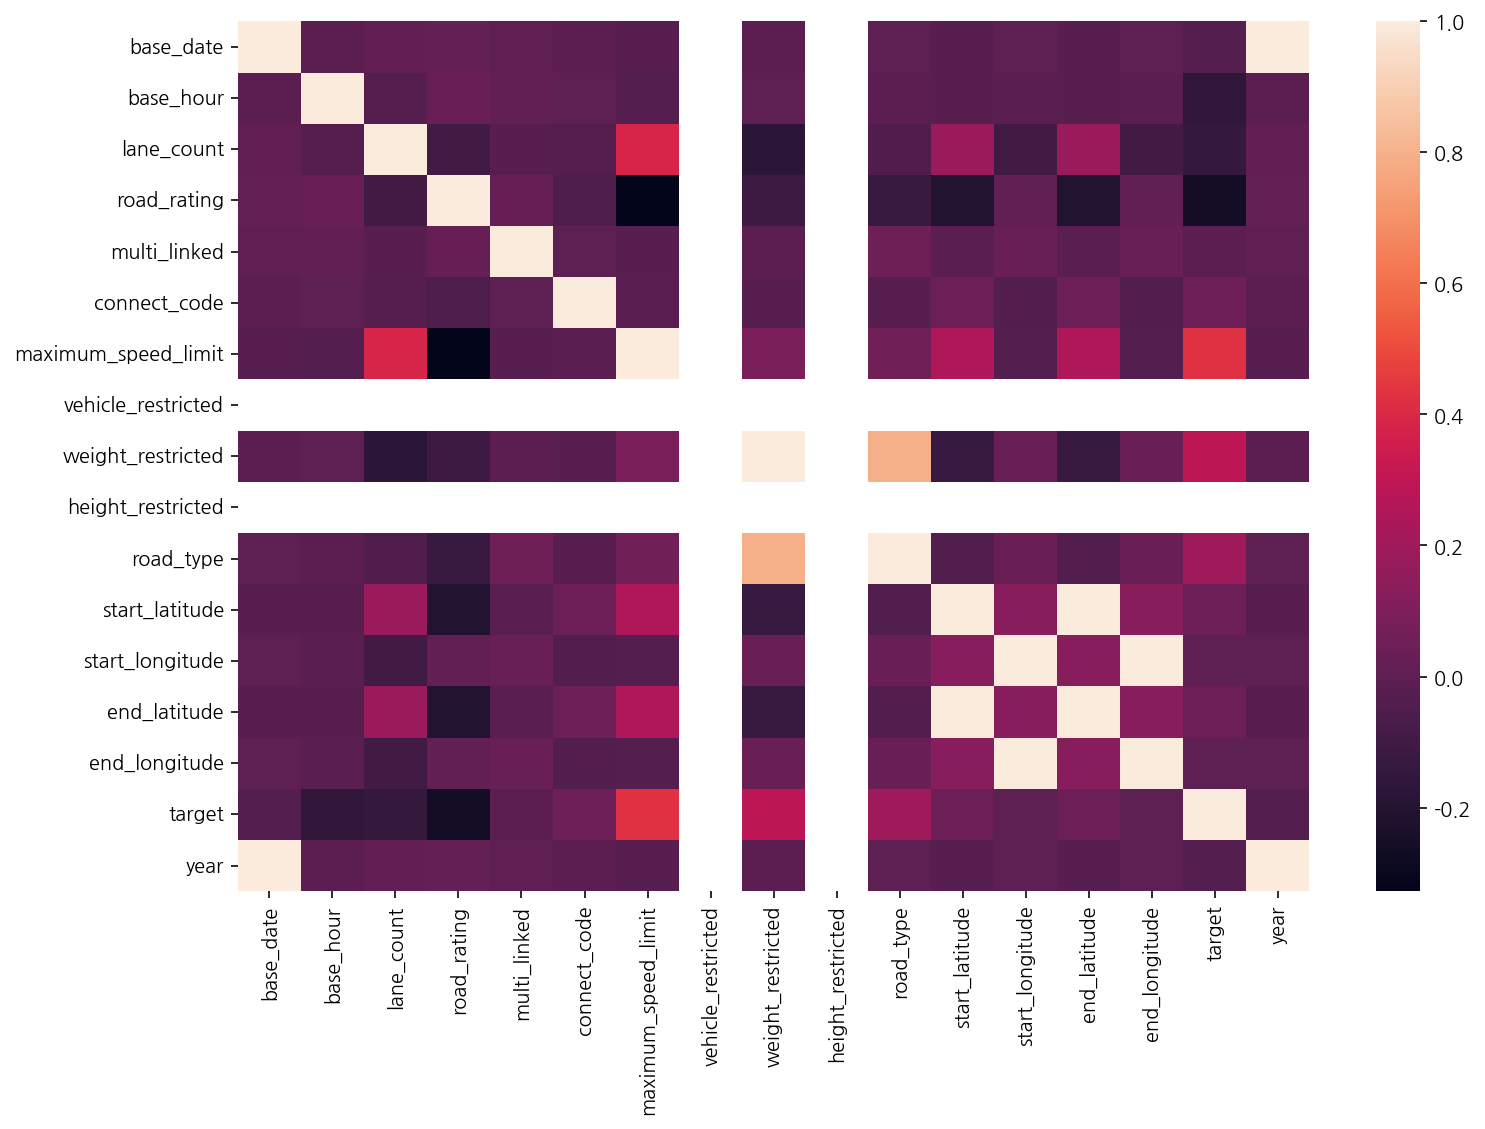

In [92]:
plt.figure(figsize=(12,8))
_=sns.heatmap(train.corr())

# 데이터 전처리

- id feature에서의 id만 남긴다.

In [94]:
# id feature에 대한 전처리
train['id'] = train['id'].str[6:]
test['id'] = test['id'].str[5:]

train['id'] = train['id'].astype(int)
test['id'] = test['id'].astype(int)

display(train.sample(3))
display(test.sample(3))

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year
4128455,4128455,20211016,토,12,2,107,-,0,0,60.0,...,보건소5거리,33.412087,126.268408,없음,나동,33.414175,126.269378,없음,33.0,20211016
1237589,1237589,20211013,수,13,2,103,일반국도12호선,0,0,60.0,...,내도동입구,33.493546,126.445105,없음,도평마을,33.493184,126.442008,없음,19.0,20211013
2979596,2979596,20220301,화,11,1,103,일반국도16호선,0,0,60.0,...,도순3교,33.258960,126.476508,없음,도순3교,33.258900,126.476922,없음,60.0,20220301


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
90302,90302,20220811,목,9,1,106,지방도1115호선,0,0,60.0,...,0.0,3,제6산록교,33.291404,126.513613,없음,제6산록교,33.291359,126.514457,없음
79736,79736,20220821,일,2,2,107,권학로,0,0,60.0,...,0.0,0,대림한숲빌라112동,33.251807,126.507558,없음,서호2차현대맨션203동,33.252183,126.506069,없음
182325,182325,20220829,월,23,2,103,일반국도16호선,0,0,60.0,...,0.0,3,색달육교,33.265988,126.414267,없음,색달육교,33.266040,126.414029,없음


- road_name feature에서의 '-'은 알 수 없음으로 변경

In [95]:
# train
name = []
for x in train['road_name']:
    if x == '-':
        name.append('알 수 없음')
    else:
        name.append(x)

train['road_name'] = name
display(train[['road_name']].sample(3))

# test
name2 = []
for x in test['road_name']:
    if x == '-':
        name2.append('알 수 없음')
    else:
        name2.append(x)

test['road_name'] = name2
display(test[['road_name']].sample(3))

,road_name
724751,일반국도16호선
387750,알 수 없음
2709810,번영로


,road_name
6513,일반국도12호선
151511,번영로
121581,일반국도11호선


- 문자열에 대한 Label Encoding

In [96]:
le = LabelEncoder()

# train
train['day_of_week'] = le.fit_transform(train['day_of_week']) 
train['road_name'] = le.fit_transform(train['road_name'])
train['start_node_name'] = le.fit_transform(train['start_node_name'])
train['start_turn_restricted'] = le.fit_transform(train['start_turn_restricted'])
train['end_node_name'] = le.fit_transform(train['end_node_name'])
train['end_turn_restricted'] = le.fit_transform(train['end_turn_restricted'])

# test
test['day_of_week'] = le.fit_transform(test['day_of_week']) 
test['road_name'] = le.fit_transform(test['road_name'])
test['start_node_name'] = le.fit_transform(test['start_node_name'])
test['start_turn_restricted'] = le.fit_transform(test['start_turn_restricted'])
test['end_node_name'] = le.fit_transform(test['end_node_name'])
test['end_turn_restricted'] = le.fit_transform(test['end_turn_restricted'])

display(train.sample(3))
display(test.sample(3))

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year
3767090,3767090,20211223,1,5,1,106,46,0,0,60.0,...,438,33.476199,126.780032,0,231,33.471026,126.776546,0,44.0,20211223
3375637,3375637,20211211,5,1,2,107,10,0,0,50.0,...,363,33.248633,126.567766,0,326,33.252019,126.567805,0,18.0,20211211
4031793,4031793,20210909,1,14,1,103,38,0,0,60.0,...,64,33.419423,126.491495,0,276,33.414733,126.481365,0,50.0,20210909


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
89875,89875,20220805,0,2,2,103,30,0,0,70.0,...,0.0,0,212,33.252390,126.443907,0,248,33.255663,126.434978,0
36835,36835,20220827,5,1,3,103,29,0,0,70.0,...,0.0,0,129,33.473494,126.545647,0,180,33.471061,126.545467,0
76871,76871,20220820,5,13,1,107,44,0,0,50.0,...,0.0,0,66,33.249551,126.571266,0,110,33.248505,126.569797,0


- 메모리를 줄이기 위한 downcasting

In [97]:
# train
for col in train.columns:
    dtype_name = train[col].dtypes.name
    if dtype_name.startswith("int"):
        if train[col].min() >= 0:
            train[col] = pd.to_numeric(train[col], downcast="unsigned")
        else:
            train[col] = pd.to_numeric(train[col], downcast="integer")
    elif dtype_name.startswith("float"):
        train[col] = pd.to_numeric(train[col], downcast="float")
    elif dtype_name == "bool":
        train[col] = train[col].astype("int8")
    elif dtype_name == "object":
        train[col] = train[col].astype("category")
        
# test
for col in test.columns:
    dtype_name = test[col].dtypes.name
    if dtype_name.startswith("int"):
        if test[col].min() >= 0:
            test[col] = pd.to_numeric(test[col], downcast="unsigned")
        else:
            test[col] = pd.to_numeric(test[col], downcast="integer")
    elif dtype_name.startswith("float"):
        test[col] = pd.to_numeric(test[col], downcast="float")
    elif dtype_name == "bool":
        test[col] = test[col].astype("int8")
    elif dtype_name == "object":
        test[col] = test[col].astype("category")
        
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     uint32 
 1   base_date              uint32 
 2   day_of_week            uint8  
 3   base_hour              uint8  
 4   lane_count             uint8  
 5   road_rating            uint8  
 6   road_name              uint8  
 7   multi_linked           uint8  
 8   connect_code           uint8  
 9   maximum_speed_limit    float32
 10  vehicle_restricted     float32
 11  weight_restricted      float32
 12  height_restricted      float32
 13  road_type              uint8  
 14  start_node_name        uint16 
 15  start_latitude         float32
 16  start_longitude        float32
 17  start_turn_restricted  uint8  
 18  end_node_name          uint16 
 19  end_latitude           float32
 20  end_longitude          float32
 21  end_turn_restricted    uint8  
 22  target            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  uint32 
 1   base_date              291241 non-null  uint32 
 2   day_of_week            291241 non-null  uint8  
 3   base_hour              291241 non-null  uint8  
 4   lane_count             291241 non-null  uint8  
 5   road_rating            291241 non-null  uint8  
 6   road_name              291241 non-null  uint8  
 7   multi_linked           291241 non-null  uint8  
 8   connect_code           291241 non-null  uint8  
 9   maximum_speed_limit    291241 non-null  float32
 10  vehicle_restricted     291241 non-null  float32
 11  weight_restricted      291241 non-null  float32
 12  height_restricted      291241 non-null  float32
 13  road_type              291241 non-null  uint8  
 14  start_node_name        291241 non-nu

None

# 모델링 학습 및 평가

- trian, test 데이터 나누기

In [101]:
label_name = 'target'

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)
y_train = train[label_name]
X_test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

display(X_train)
display(y_train)
display(X_test)

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,1,106,0,0,60.0,32400.0,0.0,3,33.427746,126.662613,0,33.427750,126.662338,0
1,1,21,2,103,0,0,60.0,0.0,0.0,0,33.500729,126.529106,1,33.504810,126.526237,0
2,4,7,2,103,0,0,80.0,0.0,0.0,0,33.279144,126.368599,0,33.280071,126.362144,0
3,0,13,2,107,0,0,50.0,0.0,0.0,0,33.246082,126.567207,0,33.245564,126.566231,0
4,6,8,2,103,0,0,80.0,0.0,0.0,0,33.462215,126.326553,0,33.462677,126.330154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,1,16,1,107,0,0,50.0,0.0,0.0,0,33.422146,126.278122,0,33.420956,126.273750,0
4701213,1,2,2,107,0,0,80.0,43200.0,0.0,3,33.472504,126.424370,0,33.472527,126.424889,0
4701214,3,22,2,103,0,0,60.0,0.0,0.0,0,33.447182,126.912582,0,33.444122,126.912949,0
4701215,2,2,2,103,0,0,80.0,0.0,0.0,0,33.443596,126.431816,0,33.444996,126.433334,0


0          52.0
1          30.0
2          61.0
3          20.0
4          38.0
           ... 
4701212    20.0
4701213    65.0
4701214    30.0
4701215    73.0
4701216    35.0
Name: target, Length: 4701217, dtype: float32

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,3,107,0,0,70.0,0.0,0.0,0,33.499428,126.541298,0,33.500774,126.543839,1
1,6,12,2,103,0,0,70.0,0.0,0.0,3,33.258507,126.427002,0,33.258118,126.415840,0
2,0,2,1,103,0,0,60.0,0.0,0.0,0,33.258961,126.476509,0,33.259205,126.474686,0
3,1,23,3,103,0,0,70.0,0.0,0.0,0,33.473495,126.545647,0,33.471062,126.545464,0
4,2,17,3,106,0,0,70.0,0.0,0.0,0,33.501476,126.569221,0,33.496864,126.581230,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,5,5,1,103,0,0,80.0,0.0,0.0,0,33.472820,126.463028,0,33.470482,126.460846,0
291237,0,20,2,103,0,0,60.0,0.0,0.0,0,33.305359,126.598915,0,33.300797,126.600334,0
291238,0,11,1,107,0,0,30.0,0.0,0.0,0,33.493622,126.496773,1,33.497501,126.496948,1
291239,0,7,2,107,0,0,60.0,0.0,0.0,0,33.254784,126.507011,0,33.255661,126.507332,0


- LightGBM 모델 선택

In [102]:
model = lgb.LGBMRegressor(random_state=42)
model

LGBMRegressor(random_state=42)

- GridSearchCV를 이용한 최적의 파라미터 구하기

In [48]:
param_lgb = {'num_leaves':[20,40,60], 
             'min_child_samples':[5,8,10],
             'max_depth':[5,10,15],
             'learning_rate':[0.05,0.01,0.1]
            }

gscv = GridSearchCV(estimator = model, param_grid=param_lgb, scoring='accuracy')
gscv.fit(X_train, y_train)
print('lgbm 파라미터 : ', gscv.best_params_)
print('lgbm 예측 정확도 : {:.4f}'.format(gscv.best_score_))

Ran 파라미터 :  {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 20}
Ran 예측 정확도 : nan


- 최적의 하이퍼파라미터를 이용한 모델링

In [103]:
model_best = lgb.LGBMClassifier(learning_rate=0.05, max_depth=5, min_child_samples=5, num_leaves=20)
model_best

LGBMClassifier(learning_rate=0.05, max_depth=5, min_child_samples=5,
               num_leaves=20)

- 최적의 모델로 학습 및 예측

In [104]:
model_best.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, min_child_samples=5,
               num_leaves=20)

In [105]:
y_predict = model_best.predict(X_test)
y_predict[:5]

array([41., 55., 28., 41., 44.], dtype=float32)

# 제출 파일 생성 및 저장

In [106]:
submission = pd.read_csv("sample_submission.csv", index_col='id')
submission

,target
id,
TEST_000000,0
TEST_000001,0
TEST_000002,0
TEST_000003,0
TEST_000004,0
...,...
TEST_291236,0
TEST_291237,0
TEST_291238,0


In [107]:
submission['target'] = y_predict
submission

,target
id,
TEST_000000,41.0
TEST_000001,55.0
TEST_000002,28.0
TEST_000003,41.0
TEST_000004,44.0
...,...
TEST_291236,41.0
TEST_291237,34.0
TEST_291238,41.0


In [110]:
submission.to_csv("lgbm_propre.csv")

In [111]:
pd.read_csv("lgbm_propre.csv")

,id,target
0,TEST_000000,41.0
1,TEST_000001,55.0
2,TEST_000002,28.0
3,TEST_000003,41.0
4,TEST_000004,44.0
...,...,...
291236,TEST_291236,41.0
291237,TEST_291237,34.0
291238,TEST_291238,41.0
291239,TEST_291239,21.0
